<a href="https://colab.research.google.com/github/Suryakumar013/Exploratory-Data-Analysis-of-Google-Play-Store-Apps/blob/main/Exploratory_Data_Analysis_of_Google_Play_Store_Apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis — Google Play Store Apps

This notebook analyzes apps + user reviews from the Google Play Store.  
We will create graphs and short explanations for each.

**Tools used:**  
- Python  
- Pandas (for data cleaning & manipulation)  
- Matplotlib & Seaborn (for visualization)  
- VADER (for sentiment analysis of user reviews)


## Step 1 — Upload the files

Run the next cell to upload the two files:
- `googleplaystore.csv`
- `googleplaystore_user_reviews.csv`



In [51]:
# Run this to upload files
from google.colab import files
uploaded = files.upload()


Saving googleplaystore.csv to googleplaystore (1).csv
Saving googleplaystore_user_reviews.csv to googleplaystore_user_reviews (2).csv


## Step 2 — Load and clean data

This next code cell:
- loads the files
- does small cleanups (Installs → numbers, Price → number, Rating → number),
- prepares `apps` and `reviews` DataFrames we will use below.


In [52]:
# Load + clean basic
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,5)

# locate files (works if uploaded via files.upload() or placed in /mnt/data)
candidates = [
  "googleplaystore.csv",
  "googleplaystore_user_reviews.csv",
  "/mnt/data/googleplaystore.csv",
  "/mnt/data/googleplaystore_user_reviews.csv"
]

apps_file = None
reviews_file = None
for p in candidates:
    if os.path.exists(p):
        if "user_reviews" in p or "reviews" in p and "googleplaystore" in p and "user" in p:
            reviews_file = p
        elif "googleplaystore" in p and "user" not in p:
            apps_file = p

# If names from upload are different, try to pick by filename pattern
if apps_file is None:
    for f in os.listdir():
        if "googleplaystore" in f and "user" not in f and f.endswith(".csv"):
            apps_file = f
if reviews_file is None:
    for f in os.listdir():
        if "review" in f.lower() and f.endswith(".csv"):
            reviews_file = f

if apps_file is None:
    raise FileNotFoundError("Cannot find googleplaystore.csv. Upload it (use earlier upload cell) or place it in /mnt/data.")
print("Apps file:", apps_file)
print("Reviews file:", reviews_file if reviews_file else "(none found)")

def safe_read(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, encoding="latin-1")

apps = safe_read(apps_file)
# basic cleaning apps
apps.columns = apps.columns.str.strip()
apps.drop_duplicates(inplace=True)
# Numeric conversions
if "Reviews" in apps.columns:
    apps["Reviews"] = pd.to_numeric(apps["Reviews"], errors="coerce")
if "Installs" in apps.columns:
    apps["Installs"] = apps["Installs"].astype(str).str.replace("+","",regex=False).str.replace(",","",regex=False)
    apps["Installs"] = pd.to_numeric(apps["Installs"], errors="coerce")
if "Price" in apps.columns:
    apps["Price"] = apps["Price"].astype(str).str.replace("$","",regex=False).replace("Free","0",regex=False)
    apps["Price"] = pd.to_numeric(apps["Price"], errors="coerce").fillna(0)
if "Rating" in apps.columns:
    apps["Rating"] = pd.to_numeric(apps["Rating"], errors="coerce")
apps = apps.dropna(subset=["App"]).reset_index(drop=True)

# Load reviews if present
reviews = pd.DataFrame()
if reviews_file:
    reviews = safe_read(reviews_file)
    reviews.columns = reviews.columns.str.strip()
    # find likely text column
    for c in ["Translated_Review","Review","review","Translated Review","Content","Review Text"]:
        if c in reviews.columns:
            text_col = c
            break
    else:
        # fallback to second column or first
        text_col = reviews.columns[1] if reviews.shape[1]>1 else reviews.columns[0]
    reviews[text_col] = reviews[text_col].astype(str).fillna("").str.strip()
    reviews = reviews[reviews[text_col].str.len()>0].copy()
    reviews = reviews.rename(columns={text_col: "clean_review"})
    reviews["clean_review"] = reviews["clean_review"].astype(str)
    print("Loaded reviews. Sample column used:", "clean_review")
else:
    print("Reviews file not found; we'll do apps-only analysis.")

print("Apps shape:", apps.shape)
print("Reviews shape:", reviews.shape)
apps.head()


Apps file: googleplaystore.csv
Reviews file: googleplaystore_user_reviews.csv
Loaded reviews. Sample column used: clean_review
Apps shape: (10358, 13)
Reviews shape: (64295, 5)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,50000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,100000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Insight 1 — Top app categories (what people publish most)

This chart shows which categories (Games, Tools, etc.) have the most apps.
It helps us see where developers focus their effort.


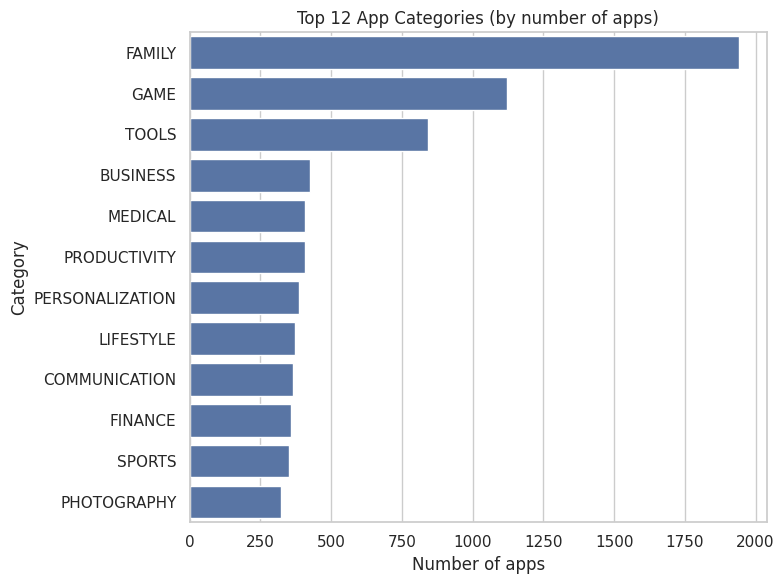

In [53]:
# Top 12 categories by app count
top_cat = apps["Category"].value_counts().head(12)
plt.figure(figsize=(8,6))
sns.barplot(x=top_cat.values, y=top_cat.index)
plt.title("Top 12 App Categories (by number of apps)")
plt.xlabel("Number of apps")
plt.tight_layout()
plt.show()


### Insight 2 — Free vs Paid apps

This shows how many apps are Free vs Paid. Most apps are usually free.


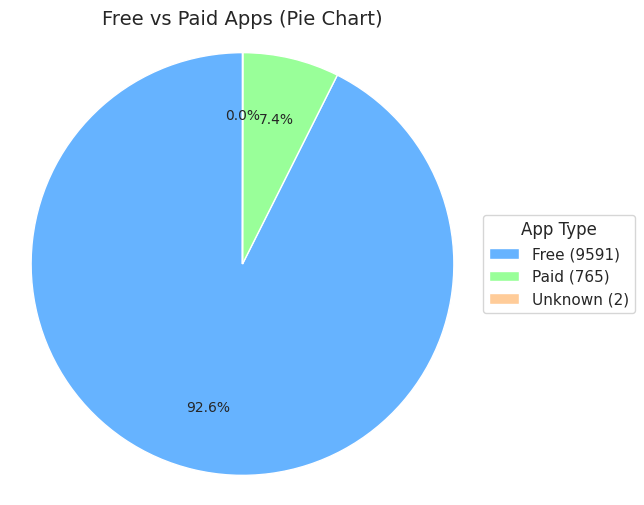

In [54]:
apps["Type"] = apps["Type"].replace("0","Unknown").fillna("Unknown")
counts = apps["Type"].value_counts()
# Pie chart
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    counts.values,
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#99ff99", "#ffcc99"],
    pctdistance=0.7,
    textprops={'fontsize': 10}
)

labels = [f"{name} ({count})" for name, count in zip(counts.index, counts.values)]
ax.legend(wedges, labels, title="App Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Free vs Paid Apps (Pie Chart)", fontsize=14)
plt.axis("equal")
plt.show()





### Insight 3 — Ratings distribution

This histogram shows how app ratings are distributed (out of 5).
Look for whether ratings cluster around 4–5 or are spread out.


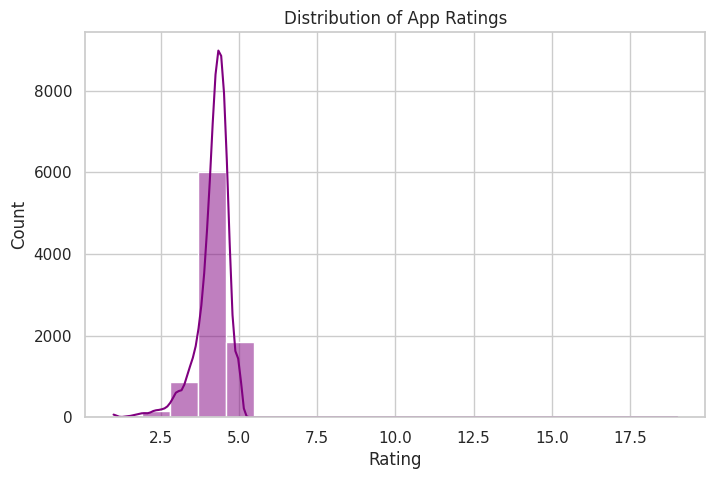

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(apps["Rating"].dropna(), bins=20, kde=True, color="purple")
plt.title("Distribution of App Ratings")
plt.xlabel("Rating")
plt.show()



### Insight 4 — Which categories get the most installs

We add up installs per category to see which category gets the most downloads.
This tells us which types of apps users actually install most.


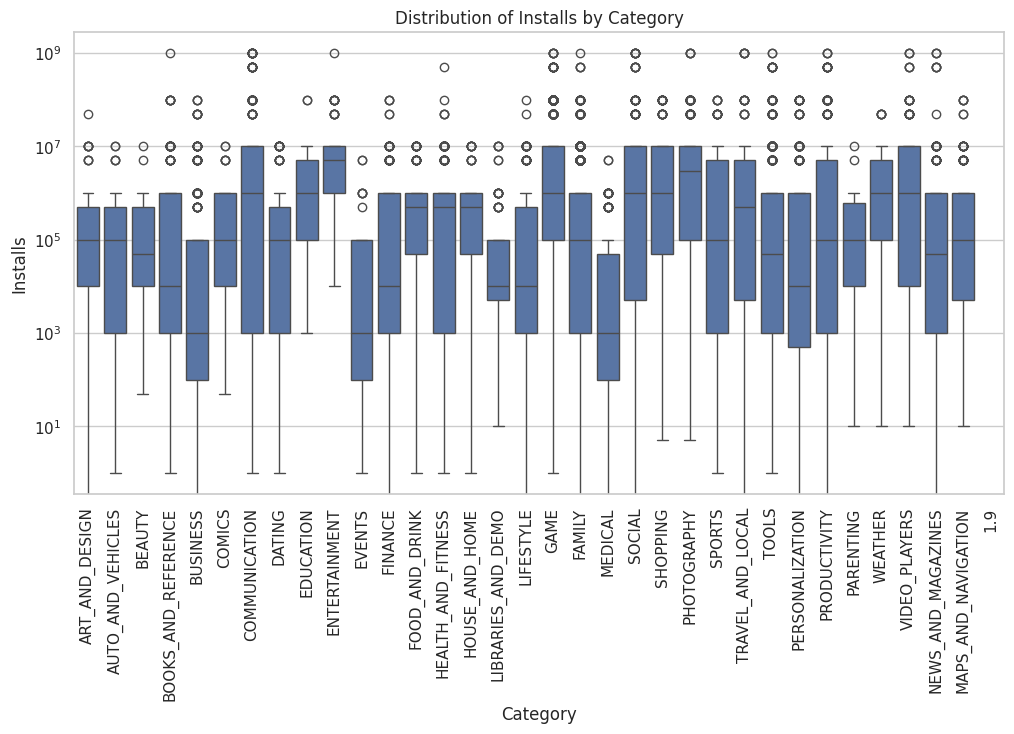

In [56]:
plt.figure(figsize=(12,6))
sns.boxplot(x="Category", y="Installs", data=apps)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Distribution of Installs by Category")
plt.show()


### Insight 5 — Top apps by installs

This shows the individual apps with the highest number of installs.
These are the very popular apps (big brands / utilities).


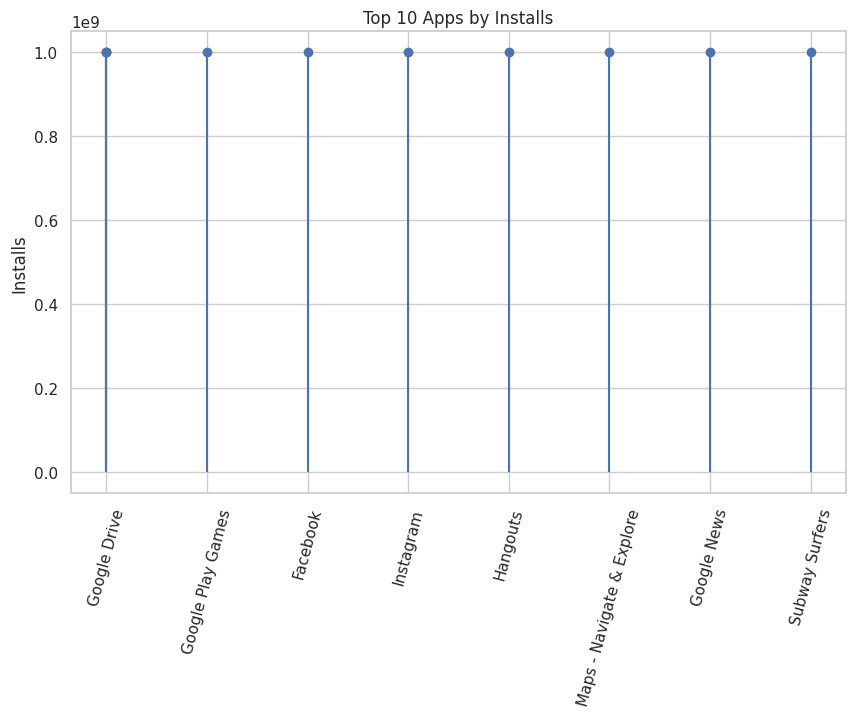

In [57]:
top_apps = apps.dropna(subset=["Installs"]).sort_values("Installs", ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.stem(top_apps["App"], top_apps["Installs"], basefmt=" ")
plt.xticks(rotation=75)
plt.title("Top 10 Apps by Installs")
plt.ylabel("Installs")
plt.show()



### Insight 6 — Reviews vs Installs (are more downloads linked to more reviews?)

This scatter plot compares number of reviews vs number of installs.
We use a log scale to make large ranges readable.


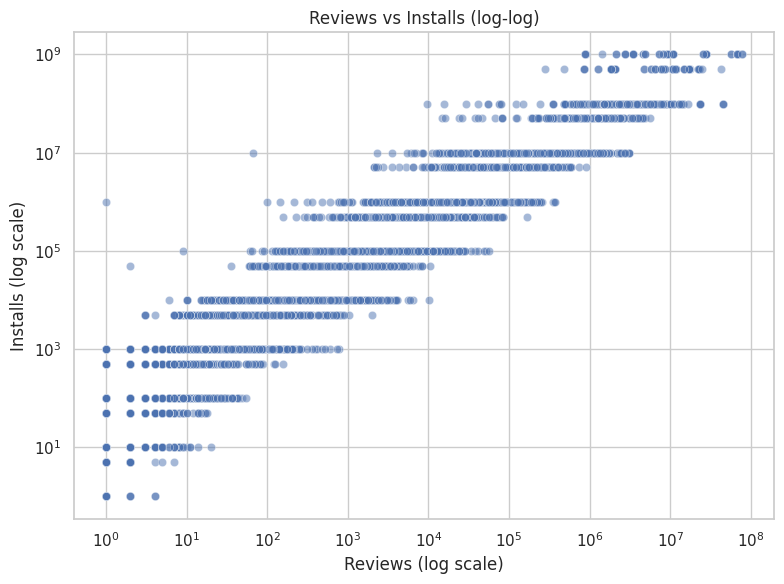

In [58]:
# Scatter: Reviews vs Installs (log scale)
tmp = apps.dropna(subset=["Reviews","Installs"])
plt.figure(figsize=(8,6))
sns.scatterplot(x="Reviews", y="Installs", data=tmp, alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title("Reviews vs Installs (log-log)")
plt.xlabel("Reviews (log scale)")
plt.ylabel("Installs (log scale)")
plt.tight_layout()
plt.show()


## Preparing review sentiment

Next we will analyze what users say. We compute a simple sentiment score for each review using **VADER**.
Run the next cell to install VADER and compute sentiment.


In [59]:
# Install VADER and compute simple sentiment scores (Colab)
# (You may see a short install message — that's normal)
!pip install -q vaderSentiment wordcloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Ensure reviews exist
if reviews.shape[0] == 0:
    print("No reviews file loaded — sentiment steps will be skipped.")
else:
    reviews["vader_compound"] = reviews["clean_review"].apply(lambda t: analyzer.polarity_scores(str(t))["compound"])
    def vlabel(c):
        if c > 0.05: return "positive"
        if c < -0.05: return "negative"
        return "neutral"
    reviews["vader_sentiment"] = reviews["vader_compound"].apply(vlabel)
    print("Computed VADER sentiment for reviews. Example:")
    display(reviews[["clean_review","vader_compound","vader_sentiment"]].head())


Computed VADER sentiment for reviews. Example:


,clean_review,vader_compound,vader_sentiment
0,I like eat delicious food. That's I'm cooking ...,0.9531,positive
1,This help eating healthy exercise regular basis,0.6597,positive
2,nan,0.0000,neutral
3,Works great especially going grocery store,0.6249,positive
4,Best idea us,0.6369,positive


### Insight 7 — Distribution of review sentiment

This shows how many reviews are positive / neutral / negative overall.
It helps us understand user feelings in general.


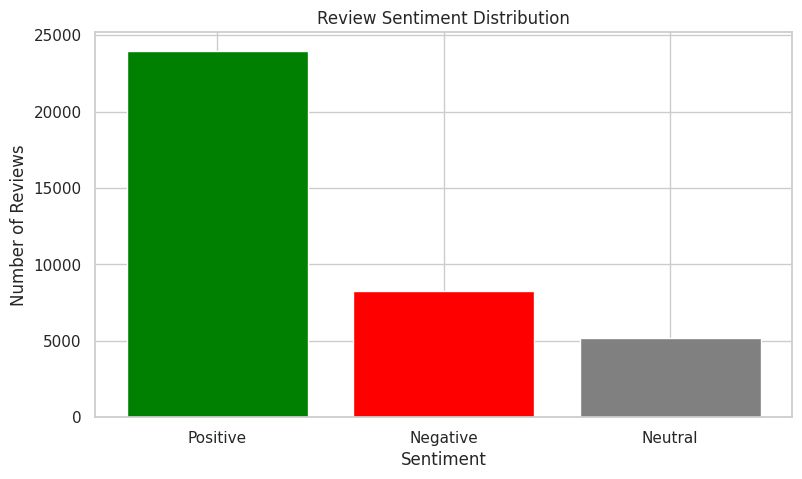

In [60]:
sent_counts = reviews["Sentiment"].value_counts()

colors = ["green","red","grey"]
plt.bar(sent_counts.index, sent_counts.values, color=colors)
plt.title("Review Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


### Insight 8 — Average review sentiment by app category

We compute average sentiment per category to see which categories get more positive reviews.
(We merge app info and review sentiment first.)


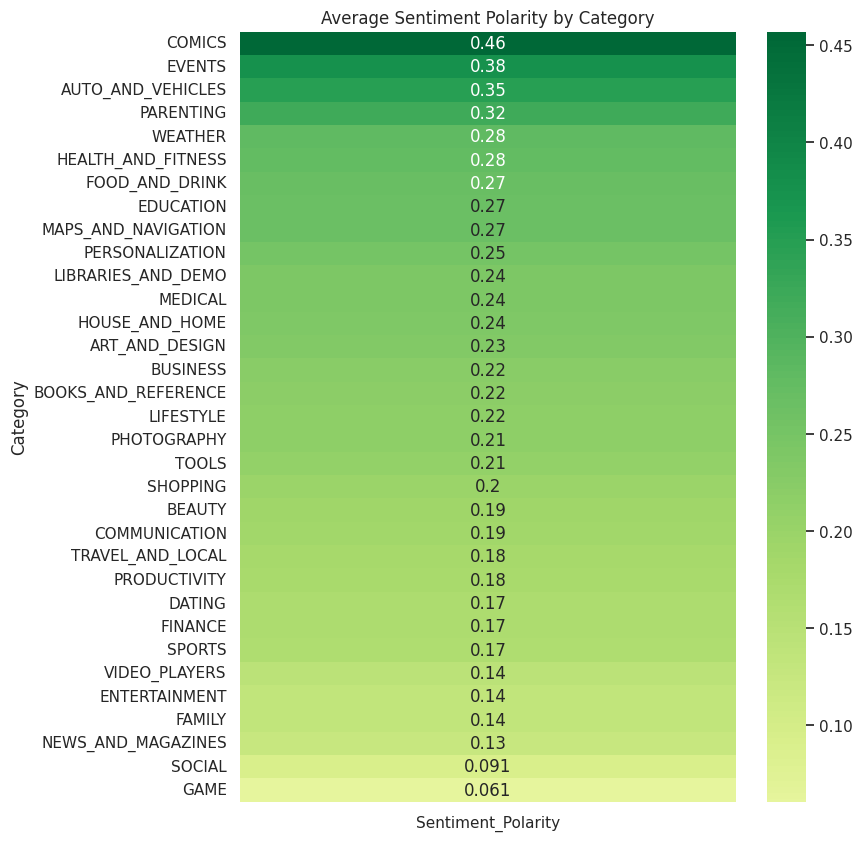

In [61]:
cat_sent = reviews.merge(apps[["App","Category"]], on="App", how="left")
cat_sent = cat_sent.groupby("Category")["Sentiment_Polarity"].mean().dropna().to_frame()

plt.figure(figsize=(8,10))
sns.heatmap(cat_sent.sort_values("Sentiment_Polarity", ascending=False), annot=True, cmap="RdYlGn", center=0)
plt.title("Average Sentiment Polarity by Category")
plt.show()


### Insight 9 — Top apps by average sentiment (with enough reviews)

Show apps with the most positive average sentiment. We require a minimum number of reviews to avoid noise.



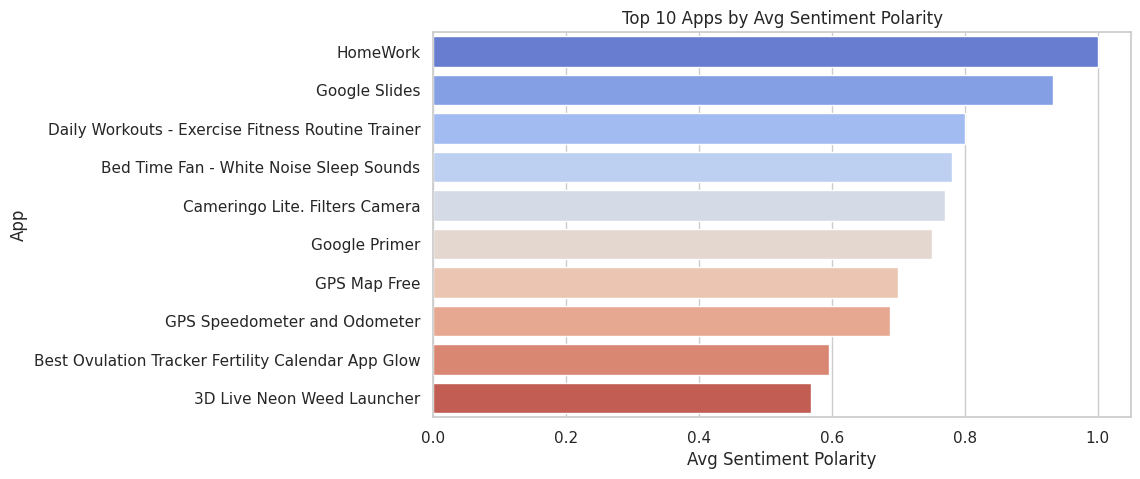

In [62]:
app_sent = reviews.groupby("App")["Sentiment_Polarity"].mean().dropna().sort_values(ascending=False).head(10)
sns.barplot(x=app_sent.values, y=app_sent.index, palette="coolwarm")
plt.title("Top 10 Apps by Avg Sentiment Polarity")
plt.xlabel("Avg Sentiment Polarity")
plt.show()



<div style="page-break-before: always;"></div>


<div style="page-break-before: always;"></div>





### Insight 10 — Wordcloud of negative reviews for one category

This shows common words people use when leaving *negative* reviews for a chosen category.



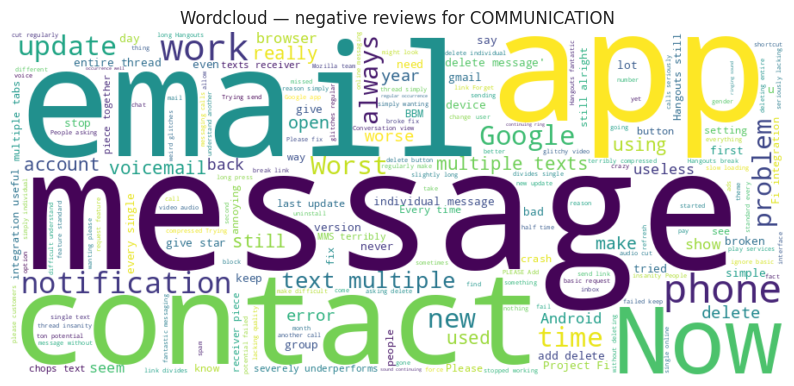

In [68]:
if reviews.shape[0] == 0:
    print("No reviews loaded. Skip wordcloud.")
else:
    from wordcloud import WordCloud, STOPWORDS
    chosen_cat = "COMMUNICATION"  # change this name if you want
    # join negative reviews for apps in that category
    neg = reviews[reviews["vader_sentiment"]=="negative"].merge(apps[["App","Category"]], on="App", how="left")
    texts = neg[neg["Category"]==chosen_cat]["clean_review"].dropna().astype(str)
    if len(texts) == 0:
        print(f"No negative reviews found for category '{chosen_cat}'. Try another category from apps['Category'].unique()")
    else:
        blob = " ".join(texts.values)[:200000]
        wc = WordCloud(width=900, height=400, background_color="white", stopwords=set(STOPWORDS)).generate(blob)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Wordcloud — negative reviews for {chosen_cat}")
        plt.show()


## Save outputs & next steps

Run the next cell to save cleaned outputs (CSV)

In [64]:
# Save outputs
try:
    apps.to_csv("apps_cleaned.csv", index=False)
    if reviews.shape[0]>0:
        reviews.to_csv("reviews_with_vader.csv", index=False)
    if 'apps_sent' in globals():
        apps_sent.to_csv("apps_with_sentiment.csv", index=False)
    print("Saved CSVs: apps_cleaned.csv", "reviews_with_vader.csv (if reviews exist)", "apps_with_sentiment.csv (if computed)")
except Exception as e:
    print("Error saving:", e)


Saved CSVs: apps_cleaned.csv reviews_with_vader.csv (if reviews exist) apps_with_sentiment.csv (if computed)


<div style="page-break-before: always;"></div>
